## Figure 5

![title](../assets/Fig5.png)

In [13]:
%load_ext autoreload
%autoreload 2
import sys
import logging
from tqdm import tqdm
from pathlib import Path

sys.path.insert(0, "./prepare_data/")

import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import Figure4_neurons as neurons
import Figure5_prepare_data as prepare_data
import connectome_utils
from common import *


DATA_PATH = Path(
    "../data"
)
EXPORT_PATH = Path(
    "../results/Figure5"
)
EXPORT_PATH.mkdir(exist_ok=True, parents=True)


FIGSIZE = {'width': 1.2, 'length': 0.9}

# disable matplotlib logger
logging.getLogger("matplotlib.font_manager").disabled = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Panel B: obtaining cell types from DBSCAN.

In [2]:
from scipy.stats import pearsonr
from sklearn.cluster import DBSCAN


In [3]:
# Load data
neuron_index = list(np.load(DATA_PATH / "neuron_names_ordered.npy")) # ordered neuron names
# Load the symmetric adjacency matrix, for its construction, see EDFigure 10
sym_adj_matrix = np.load(DATA_PATH / "Fig5_symmetric_adj_matrix_max.npy")

In [4]:
# only one side, without sensory or motor neurons
neuron_ind_wo_sensorymotor = [
    neuron_index.index(name)
    for name in neuron_index
    if name[:3] not in ['JO-', 'BM-', 'ANT', 'NEC'] and name[-1] == 'L'
]
neuron_ind_left = [
    neuron_index.index(name)
    for name in neuron_index
    if name[-1] == 'L'
]

# Find best matches for a given neuron
similarity_score = []
for n_ind in tqdm(neuron_ind_wo_sensorymotor):
    similarity_score.append(
        prepare_data.calc_similarity_score(n_ind, sym_adj_matrix, indices_to_lookat=neuron_ind_wo_sensorymotor)
    )

similarity_score_matrix = np.array(similarity_score)

  0%|          | 0/167 [00:00<?, ?it/s]/Users/ozdil/anaconda3/envs/ntw_model/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 167/167 [00:37<00:00,  4.41it/s]


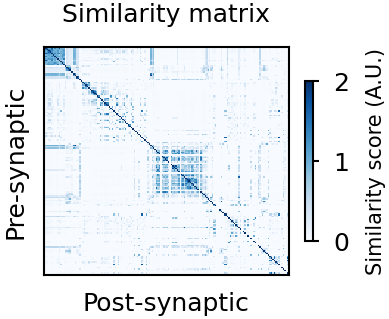

In [5]:
with plt.style.context("./config.mplstyle"):
    # plot the adjacency matrix
    fig, ax = plt.subplots(
        figsize=(FIGSIZE["width"] * 1.1, FIGSIZE["length"] * 1.1), dpi=300
    )
    cax = ax.matshow(
        similarity_score_matrix.T,
        cmap="Blues",
        aspect="auto",
        vmin=0, vmax=2 # Dont show very dissimilar results
    )
    # add color map
    cbar = plt.colorbar(cax, shrink=0.7)
    cbar.set_label("Similarity score (A.U.)", fontsize=5)
    ax.set_title("Similarity matrix", fontsize=6)

    ax.spines["right"].set_visible(True)
    ax.spines["top"].set_visible(True)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel("Post-synaptic")
    ax.set_ylabel("Pre-synaptic")
    fig.savefig(
        EXPORT_PATH / "Fig5_panelB_simmatrix.png",
        bbox_inches="tight",
    )
    plt.show()

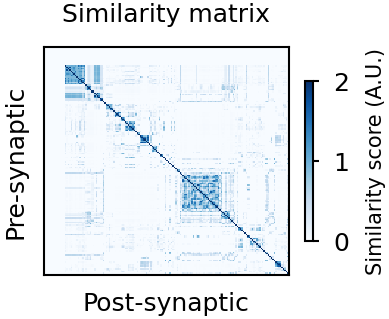

In [6]:

order, ordered_sim_matrix = prepare_data.cluster_by_dbscan(
    similarity_score_matrix, eps=0.5, min_samples=1
)


with plt.style.context("./config.mplstyle"):
    # plot the adjacency matrix
    fig, ax = plt.subplots(
        figsize=(FIGSIZE["width"] * 1.1, FIGSIZE["length"] * 1.1), dpi=300
    )
    cax = ax.matshow(ordered_sim_matrix.T, cmap="Blues", aspect="auto", vmin=0, vmax=2)
    # add color map
    cbar = plt.colorbar(cax, shrink=0.7)
    cbar.set_label("Similarity score (A.U.)", fontsize=5)
    ax.set_title("Similarity matrix", fontsize=6)

    ax.spines["right"].set_visible(True)
    ax.spines["top"].set_visible(True)

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel("Post-synaptic")
    ax.set_ylabel("Pre-synaptic")

    cbar.set_label("Similarity score (A.U.)")
    fig.savefig(
        EXPORT_PATH / "Fig5_panelB_clustered_simmatrix.png", bbox_inches='tight'

    )
    plt.show()

## Panel D: test error per model.

Here, we only plot the results. In order to reproduce the data itself, please refer to the readme file in the main directory.

/var/folders/tq/lmjf3_8j2pgc58qrzj3pl2x00000gp/T/ipykernel_16615/4276817493.py:8: UserWarning: 
The palette list has fewer values (1) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


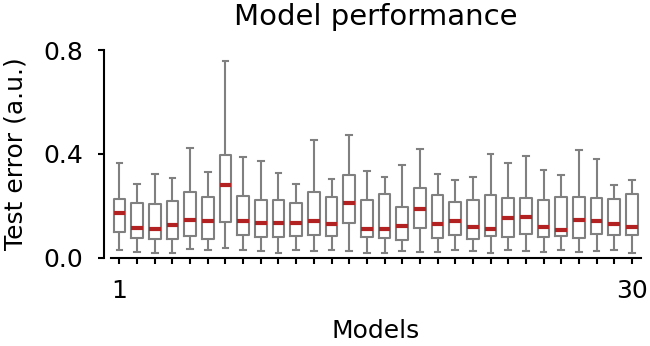

In [7]:
test_error = load_data(DATA_PATH / "Fig5_panelD_test_error.pkl")

with plt.style.context("./config.mplstyle"):
    # plot the column "silence_" with respect to seeds
    fig, ax = plt.subplots(
        figsize=(FIGSIZE["width"] * 1.9, FIGSIZE["length"] * 1.0), dpi=300
    )
    sns.boxplot(
        # data=test_error["silence_"],
        x=test_error["seed"],
        y=test_error["silence_"],
        ax=ax,
        showfliers=False,
        width=0.65,
        palette=["grey"],
        fill=False,
        linewidth=0.5,
        order=sorted(test_error.seed.unique()),
        medianprops=dict(color="firebrick", lw=1),
    )
    ax.spines["left"].set_position(("outward", 1.5))  # 10 points outward for y-axis
    ax.spines["bottom"].set_position(("outward", 0))  # 10 points outward for x-axis
    ax.set_ylim(0, 0.8)
    ax.set_yticks(np.arange(0, 0.81, 0.4))
    ax.set_xticks(np.arange(0, len(test_error.seed.unique())), labels=[1] + ['']*28 + [30], fontsize=6, rotation=0)

    ax.set_ylabel("Test error (a.u.)")
    ax.set_xlabel("Models")
    ax.set_title("Model performance")
    fig.savefig(
        EXPORT_PATH / "Fig5_panelD.png", bbox_inches="tight", dpi=300
    )
    plt.show()

## Panel F: calculating unilateral selectivity index of antennal grooming neurons in each model. 

In [8]:
# Load data
asym_input_response = load_data(DATA_PATH / "Fig5_panelF_JO-F_L_5_R_3.pkl")
seed_numbers = list(asym_input_response.keys())

# Antennal grooming neurons to look at
neuron_types = ["ABN", "ADN", "ANTEN_MN"]
left_neurons = [
    i
    for i, name in enumerate(neuron_index)
    for neuron_type in neuron_types
    if neuron_type in name and "L" in name
]
right_neurons = [
    i
    for i, name in enumerate(neuron_index)
    for neuron_type in neuron_types
    if neuron_type in name and "R" in name
]

# Format names
neuron_names = [neuron_index[i][:-2].replace('ANTEN_','A').replace('_','-') for i in left_neurons]

# Compute unilateral selectivity index
asym_response_USI = prepare_data.get_act_difference(
    asym_input_response,
    seed_numbers,
    left_neurons=left_neurons,
    right_neurons=right_neurons,
    start=2550,
    end=4500,
)


/Users/ozdil/Desktop/PhD/Manuscripts/TRIPATITE_2023/antennal-grooming/src/./prepare_data/Figure5_prepare_data.py:117: RuntimeWarning: invalid value encountered in scalar divide
  ratio = (right_area[0] - left_area[0]) / (right_area[0] + left_area[0])


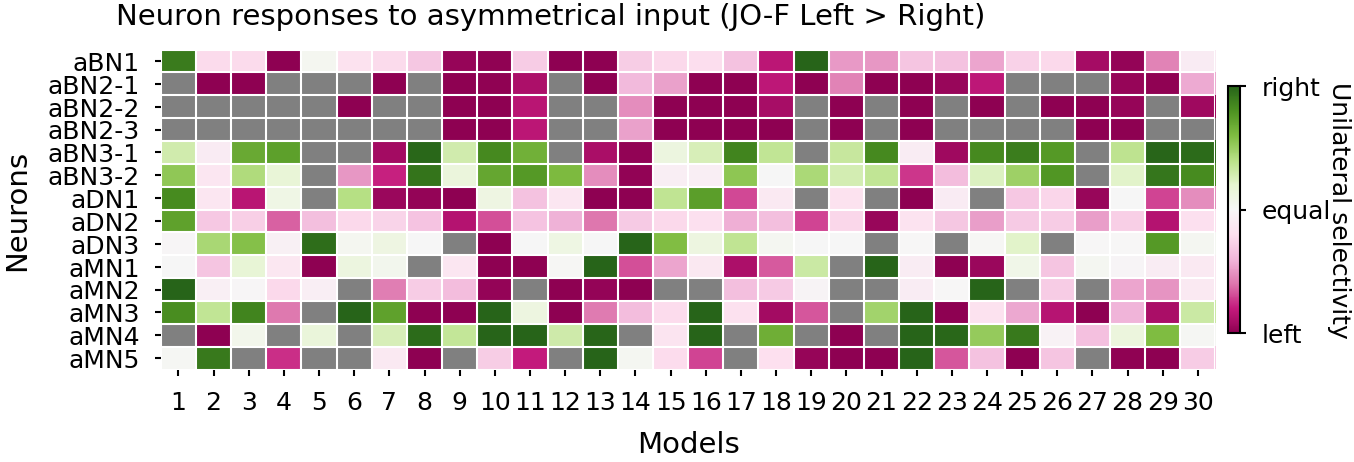

In [9]:
with plt.style.context("./config.mplstyle"):
    fig, ax = plt.subplots(figsize=(FIGSIZE["width"] * 4.5, FIGSIZE["length"] * 1.7), dpi=300)

    cmap = mpl.colormaps.get_cmap("PiYG")
    cmap.set_bad(color="#808080")

    cax = ax.imshow(asym_response_USI.T, cmap=cmap, aspect=0.65, vmin=-1, vmax=1)

    # Add grid lines between cells
    ax.set_xticks(np.arange(-0.5, asym_response_USI.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, asym_response_USI.shape[1], 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", size=0.0)
    ax.grid(False)

    # Add a color bar (legend) for the heatmap
    cbar = fig.colorbar(cax, ax=ax, shrink=0.7, pad=0.01)
    cbar.set_label("Unilateral selectivity", rotation=270, labelpad=5)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["left", "equal", "right"])

    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_xticks(np.arange(len(seed_numbers)), labels=np.arange(1, len(seed_numbers) + 1), rotation=0)
    ax.set_xlabel("Models", fontsize=7)
    ax.set_ylabel("Neurons", fontsize=7)
    neurons_names_updated = [name.replace('A','a') for name in neuron_names]
    ax.set_yticks(np.arange(len(neuron_names)), labels=neurons_names_updated)

    ax.set_title(f"Neuron responses to asymmetrical input (JO-F Left > Right)", x=0.37)
    # Show the plot
    fig.savefig(
        EXPORT_PATH / f"Fig5_panelF_activity_difference.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

## Panel G: distribution of USI values

/var/folders/tq/lmjf3_8j2pgc58qrzj3pl2x00000gp/T/ipykernel_16615/3147777202.py:16: UserWarning: 
The palette list has fewer values (1) than needed (14) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


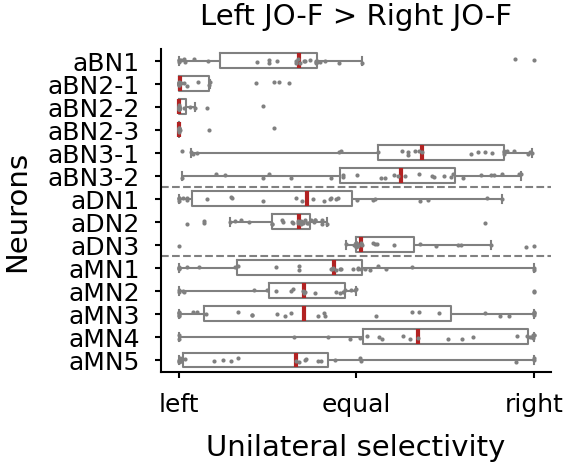

In [10]:
neuron_dist = {}

for neuron_id, neuron_name in enumerate(neuron_names):
    # NaN values are excluded
    neuron_dist[neuron_name] = list(asym_response_USI[
        ~np.isnan(asym_response_USI[:, neuron_id]), neuron_id
    ])

with plt.style.context("./config.mplstyle"):

    fig, ax = plt.subplots(figsize=(FIGSIZE["width"] * 1.4, FIGSIZE["length"] * 1.55), dpi=300)

    # sort keys and values together
    sorted_keys, sorted_vals = zip(*neuron_dist.items())

    sns.boxplot(
        data=sorted_vals,
        orient="h",
        ax=ax,
        showfliers=False,
        width=0.65,
        palette=["grey"],
        fill=False,
        linewidth=0.5,
        medianprops=dict(color="firebrick", linewidth=1),
    )

    sns.stripplot(
        data=sorted_vals,
        size=1,
        color="grey",
        orient="h",
        linewidth=0,
        alpha=1
    )

    ax.set_xlabel("Unilateral selectivity", fontsize=7)
    ax.set_ylabel("Neurons", fontsize=7)
    ax.set_yticks(np.arange(len(neuron_names)), labels=neurons_names_updated)

    ax.set_xticks([-1, 0, 1], labels=["left", "equal", "right"])
    ax.set_title(f"Left JO-F > Right JO-F")

    ax.axhline(5.5, ls="--", lw=0.5, color="grey")
    ax.axhline(8.5, ls="--", lw=0.5, color="grey")

    fig.savefig(
        EXPORT_PATH / f"Fig5_panelG_neuron_resp.png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()